# Common import statements
For different splits go to the respective sections.

## Be aware:
The notebook writes to csv files a few time to save (intermediate) results. Better not run the whole notebook. 

In [1]:
import pandas as pd
from pandas import DataFrame as df
import IPython as ip
import re
import numpy as np
import time

import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
# Set input dir
import sys
sys.path.append("/home/mschlupp/pythonTools")
files_dir = "files/"
%matplotlib inline

## Split data into `hasEvents` and `noEvents`

In [ ]:
ga_full = pd.read_csv(files_dir+"traintest_fullevt.csv")

In [ ]:
ga_hasEvts = ga_full[ga_full.hasEvents>0]

In [ ]:
ga_noEvts = ga_full[ga_full.hasEvents==0]

In [ ]:
ga_noEvts = ga_noEvts.drop(["hasEvents", "nEvts", "longitude_mean"
                , "longitude_variance", "latitude_mean"
                , "latitude_variance", "usageTime_mean"
                , "usageTime_variance", "usageDay_mean"
                ,"usageDay_variance"], axis=1)

In [ ]:
ga_noEvts.to_csv("files/ga_noEvts.csv", index=False)

In [ ]:
ga_hasEvts.to_csv("files/ga_hasEvts.csv", index=False)

In [ ]:
%ls files/

## Split events data in ```hasApp``` and ```noApp```

In [ ]:
evts= pd.read_csv("files/events_day_hour.csv", index_col=0)

In [ ]:
ga_evts = pd.read_csv("files/ga_hasEvts.csv")

In [ ]:
ga_evts.tail(2)

There are actually devide_ids that are not in the training and test set, but present in the events data. First get rid of those.

Eg:

In [ ]:
-8295895346874348777 in ga_evts.device_id.values

In [ ]:
# this is not very fast!
#ll = evts.device_id.map(lambda x: x in ga_evts.device_id.values)
#ll.value_counts()

#True     3160417
#False      92533
#Name: device_id, dtype: int64

In [ ]:
# ask if the evts.device_id is in ga_evts
evts=evts.drop(["timestamp"],axis=1)
evts=evts[list(map(lambda x: x in ga_evts.device_id.values,evts.device_id))]

In [ ]:
len(evts)

In [ ]:
evts.to_csv("files/evts_ga_aligned_ids.csv", index=False)

Ok now all `device_id` entries are present in the train and test samples.

In [ ]:
#read file in chunks, because else we run in memory troubles
size=50000
evts_chunks= pd.read_csv("files/evts_ga_aligned_ids.csv", chunksize=size)

In [ ]:
evts = pd.DataFrame()

In [ ]:
# this got a bit more complicated than necessary due to missing device ids

# add training flag and write output to file
#start=time.time()
#for i,chunk in enumerate(evts_chunks): 
#    l=list()
#    for x in chunk.device_id.values:
#        l.append(ga_evts[ga_evts.device_id==x].isTrain.values[0])    
#    chunk["isTrain"]=l
    #print(type(l), "\n", l)
#    if i % 10 == 0:
#        t = time.time()
#        print(i*size/1e3, "k events processed! Took: ", (t-start)/60., " minutes.")
#    if i==0:
#        evts = chunk #.to_csv("files/finalSets/evts_withTrain.csv", mode='w')
#    else:
#        evts = evts.append(chunk, ignore_index=True) #.to_csv("files/finalSets/evts_withTrain.csv", mode='a',header=False)
        
# print("\n\n done in ", (time.time()-s)/60., " minutes")
# horribly slow: about 50 minutes

# try to be faster
# that's so much faster!! --> 0.8 minutes!
start=time.time()
for i,chunk in enumerate(evts_chunks): 
    chunk = chunk.merge(ga_evts[["device_id","isTrain", "group"]]
                        ,on="device_id", how="left")
    #print(type(l), "\n", l)
    if i % 10 == 0:
        t = time.time()
        print((i+1)*size/1e3, "k events processed! Took: ", (t-start)/60., " minutes.")
    if i==0:
        evts = chunk 
    else:
        evts = pd.concat([evts,chunk], ignore_index=True)
        
print("\n\n done in ", (time.time()-start)/60., " minutes")

In [ ]:
# take device with highest amount of events occurrances
evts.device_id.value_counts().head(1)

In [ ]:
# test if the merge was successful
print(ga_evts.isTrain[ga_evts.device_id==1186608308763918427])
evts[evts.device_id==1186608308763918427].isTrain.value_counts()

Ok this worked.
Even for the device with the highest number of event occurrences, the `isTrain` flag is correctly set for all of them! Great improvement in speed!!

In [ ]:
evts.to_csv(files_dir+"finalSets/evts_withTrain.csv", index=False)

## We start to split data

In [ ]:
evts = pd.read_csv("files/finalSets/evts_withTrain.csv")

In [ ]:
len(evts)

In [ ]:
# now we need the event ids from the apps data
app_evt_id = pd.read_csv("files/app_events.csv", usecols=["event_id"]
                         , dtype=np.float64)

In [ ]:
app_evt_id =  pd.DataFrame(app_evt_id.event_id.unique(), columns=["event_id"])

In [ ]:
len(app_evt_id)

In [ ]:
evts_hasApp = evts.merge(app_evt_id, on="event_id", how="inner")

In [ ]:
print(len(evts_hasApp))
evts_hasApp.head(5)

In [ ]:
evts_hasApp.to_csv(files_dir+"finalSets/evts_hasApp.csv", index=False)

In [ ]:
evts_noApp = evts.loc[~(evts["event_id"].isin(evts_hasApp.event_id))]

In [ ]:
len(evts_noApp)+len(evts_hasApp) == len(evts)

Cool this worked. Now write the last split to csv and call it a day.

In [ ]:
evts_noApp.to_csv(files_dir+"finalSets/evts_noApp.csv", index=False)

# Now continue with the AppData
Here we need to merge the app data with the events data that have App information

In [3]:
evts_hasApp = pd.read_csv(files_dir+"finalSets/evts_hasApp.csv")

In [ ]:
print(evts_hasApp.shape)
evts_hasApp.head(2)

This dataset will be merged with the app information. So let's get the app data.

In [ ]:
%ls files | grep "app"

In [4]:
app_info = pd.read_csv(files_dir+"app_events.csv")

In [ ]:
print(app_info.shape)
app_info.head(2)

#### To understand the app data, we'll take an example chunk and look at it

In [ ]:
evts_hasApp.event_id[evts_hasApp.device_id==-6401643145415154744].head()

In [ ]:
app_info = app_info[app_info.event_id.isin([2,65269,212044,346841,349776])]

In [ ]:
group_evt = app_info.groupby("event_id")

In [ ]:
for x in group_evt.groups:
    print(group_evt.get_group(x))

It seems as if there are different active apps per event and device. Sometimes there is also information about the if an app is installed or not.
From now on we only consider app information about the apps that are installed and active in an event. Indeed, there are no app that are active but not installed.

In [ ]:
# load full data again and then drop all that is not active in one event
app_info = pd.read_csv(files_dir+"app_events.csv")

In [ ]:
# lets check if there are events with no active app
app_info.groupby("event_id")["is_active"].agg(np.sum).value_counts().sort_index().head(2)

In [7]:
df = pd.DataFrame({"nActiveApps" : app_info.groupby("event_id")["is_active"].agg(np.sum),
                   "nInstallApps" : app_info.groupby("event_id")["is_installed"].agg(np.sum)})
df["event_id"] = df.index
df.index= range(len(df))

In [9]:
# ok there are events with no active app
# let's create a feature that counts the number of active apps per event
evts_hasApp = evts_hasApp.merge(df, on="event_id", how="left")

In [10]:
gp = evts_hasApp.groupby("group")

/home/mschlupp/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


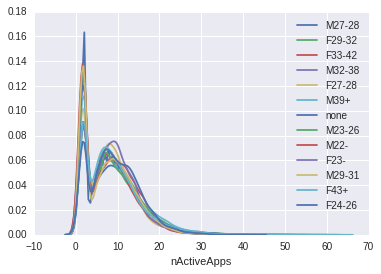

In [11]:
for x in gp.groups:
    sns.distplot(gp.get_group(x).nActiveApps, hist=False, label=x);

/home/mschlupp/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


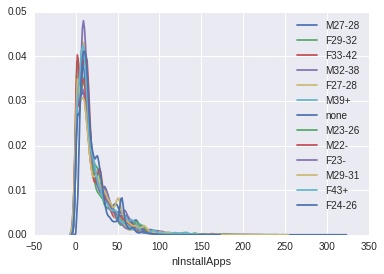

In [12]:
for x in gp.groups:
    sns.distplot(gp.get_group(x).nInstallApps, hist=False, label=x);

Here we have minor differences for the number of active apps, which might help us with other variables. For the number of installed apps

In [13]:
evts_hasApp.head(2)

,event_id,device_id,longitude,latitude,day,time,hour,usageDay,isTrain,group,nActiveApps,nInstallApps
0,2,-6401643145415154744,103.65,30.97,Sun,00:54:12,0,3,0,none,6,19
1,6,1476664663289716375,0.00,0.00,Sun,00:27:21,0,3,1,M22-,15,38


In [14]:
# store the new variable in file
evts_hasApp.to_csv("files/finalSets/evts_withApp_ActInst.csv")

#### Merge and clean app data

In [2]:
app_info = pd.read_csv(files_dir+"app_events.csv")

In [3]:
evts_hasApp = pd.read_csv("files/finalSets/evts_withApp_ActInst.csv",usecols=["event_id"])

First we get rid of all the entries of the app data that have no corresponding event_id in the events data.
Additionally we focus on the active app.

In [4]:
app_info = app_info.loc[(app_info.is_active ==1)]
app_info = app_info.loc[app_info.event_id.isin(evts_hasApp.event_id)]

In [5]:
app_info = app_info.drop(["is_installed","is_active"], axis=1)

In [7]:
app_info.to_csv("files/finalSets/apps.csv", index=False)

### Merge labels and apps
In the end, we can drop app_id completely and only use the app label.

We'd like to categorise the `app_id`s so we need label information.

In [8]:
del evts_hasApp
del app_info

In [10]:
# ok, let's continue with the grouped labels
app_info = pd.read_csv("files/finalSets/apps.csv", chunksize=30000)
label = pd.read_csv(files_dir+"finalSets/app_categories_grouped.csv")

In [5]:
app = pd.DataFrame()
for i,x in enumerate(app_info):
    if i == 2: 
        break
    x=x.merge(label,on="app_id", how="left")
    if i== 0:
        app = x
    else:
        app = pd.concat([app,x], ignore_index=True)

In [11]:
app_info.read().head()

,event_id,app_id
0,2,5927333115845830913
1,2,-653184325010919369
2,2,8693964245073640147
3,2,4775896950989639373
4,2,7167114343576723123


In [12]:
label[label.app_id==5927333115845830913]

,app_id,general_groups
3152,5927333115845830913,cat_Property
8139,5927333115845830913,cat_Family
69351,5927333115845830913,cat_Property
187954,5927333115845830913,cat_Industry tag
430991,5927333115845830913,cat_Communication


This is unfortunate. The app_id is bijective with the label_id and category. Yes, an app might fall into more than one category.
Now we need a way to deal with this. 

### Deal with multiple labels per app id

In [13]:
label = pd.read_csv(files_dir+"finalSets/app_categories_grouped.csv")

In [12]:
app_info.head(10)

,event_id,app_id,general_groups
0,2,5927333115845830913,cat_Property
1,2,5927333115845830913,cat_Family
2,2,5927333115845830913,cat_Property
3,2,5927333115845830913,cat_Industry tag
4,2,5927333115845830913,cat_Communication
5,2,-653184325010919369,cat_Custom label
6,2,-653184325010919369,cat_Esoteric
7,2,-653184325010919369,cat_Finance
8,2,-653184325010919369,cat_Finance
9,2,-653184325010919369,cat_Finance


# ToDo:
- drop entries in app_info which don't have corresponding information in the events dataset
- merge app_info with labels.
- merge app_info with events info, drop dublicates.
- write device_id to app data
- prepare datasets: normalisations, transformation, encoding... 
- train models!
- try to optimise ensemble output, there will be many predictions for each device_id when we train on events or app data.
- curious what comes out of it.